In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization, LeakyReLU, Embedding, multiply, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.utils import to_categorical

# Define input image dimensions
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100

# Load the dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Convert to float and Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)


4422102/4422102 [==============================] - 0s 0us/step


In [2]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim + num_classes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(num_classes,))
    model_input = Concatenate()([noise, label])

    img = model(model_input)

    return Model([noise, label], img)

def build_discriminator():
    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape) + num_classes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    label = Input(shape=(num_classes,))
    label_embedding = Flatten()(label)
    flat_img = Flatten()(img)
    model_input = Concatenate()([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
27502 [D loss: 0.6489145457744598, acc.: 50.0] [G loss: 0.8813852071762085]
1/1 [==============================] - 0s 40ms/step
27503 [D loss: 0.5844605267047882, acc.: 71.875] [G loss: 1.0247077941894531]
1/1 [==============================] - 0s 32ms/step
27504 [D loss: 0.6738320291042328, acc.: 59.375] [G loss: 0.8685134053230286]
1/1 [==============================] - 0s 44ms/step
27505 [D loss: 0.6503060162067413, acc.: 62.5] [G loss: 0.8481506109237671]
1/1 [==============================] - 0s 36ms/step
27506 [D loss: 0.6840030252933502, acc.: 59.375] [G loss: 0.8806506395339966]
1/1 [==============================] - 0s 41ms/step
27507 [D loss: 0.6818914115428925, acc.: 65.625] [G loss: 0.9511100053787231]
1/1 [==============================] - 0s 33ms/step
27508 [D loss: 0.6343167424201965, acc.: 53.125] [G loss: 0.9461219310760498]
1/1 [==============================] - 0s 4

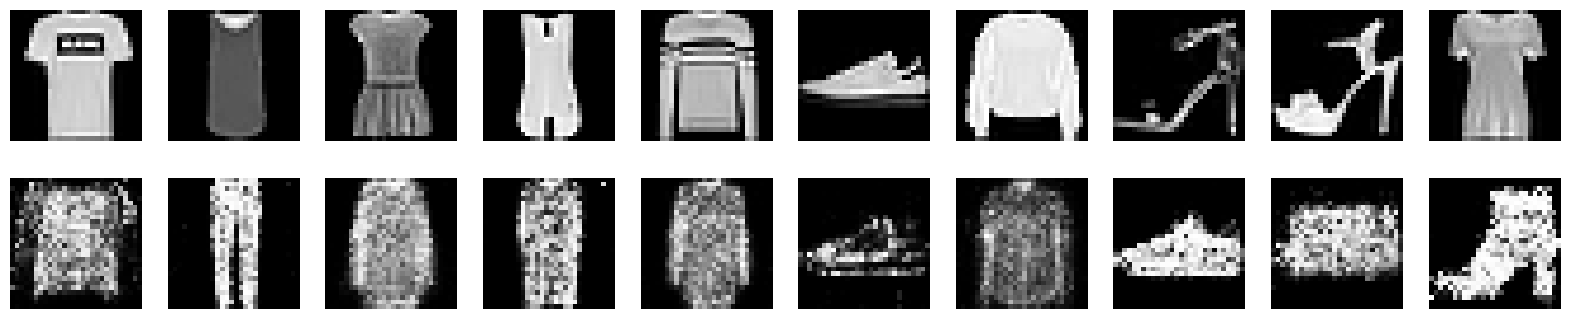

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create directory for saving images
os.makedirs('images', exist_ok=True)

# Hyperparameters
epochs = 30000
batch_size = 16

# Prepare the labels
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0002, 0.5))

# The generator takes noise and the target label as input
z = Input(shape=(latent_dim,))
label = Input(shape=(num_classes,))
img = generator([z, label])

# For the combined model, only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
valid = discriminator([img, label])

# Combined model (stacked generator and discriminator)
combined = Model([z, label], valid)
combined.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0002, 0.5))

# Function to save generated images
def save_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    labels = np.array([num for _ in range(examples // 10) for num in range(10)])
    labels = to_categorical(labels, num_classes)

    generated_images = generator.predict([noise, labels])
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"images/epoch_{epoch}.png")
    plt.close()

# Training the cGAN
for epoch in range(epochs):
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    labels = y_train[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], real_labels)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = combined.train_on_batch([noise, labels], real_labels)

    # Print the progress
    print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval, save generated image samples
    if epoch % 1000 == 0:
        save_images(generator, epoch)

def real_vs_fake(generator):
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    noise = np.random.normal(0, 1, (10, latent_dim))
    labels = np.array([num for num in range(10)])
    labels = to_categorical(labels, num_classes)

    # Generate fake images
    gen_imgs = generator.predict([noise, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot real images in the first row
    for i in range(10):
        axes[0, i].imshow(X_train[i + 1, :, :, 0], cmap='gray')  # Shift by 1
        axes[0, i].axis('off')

    # Plot fake images in the second row
    for i in range(10):
        axes[1, i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Real")
    axes[1, 0].set_ylabel("Fake")
    plt.show()

real_vs_fake(generator)
